In [ ]:
# default_exp modeling

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# modeling

> This module contains custom models, loss functions, and a default layer group splitter for use in applying discriminiative learning rates to your huggingface models trained via fastai

In [ ]:
#export
from blurr.utils import *
from blurr.data import *

import torch
from transformers import *
from fastai2.text.all import *

In [ ]:
#hide
import pdb

from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


## Base splitter and model wrapper

In [ ]:
#export
def hf_splitter(m):
    """Splits the huggingface model based on various model architecture conventions"""
    root_modules = list(m.hf_model.named_children())
    top_module_name, top_module = root_modules[0]
    
    groups = L([ m for m_name, m in list(top_module.named_children()) ])
    groups += L([ m for m_name, m in root_modules[1:] ])

    return groups.map(params).filter(lambda el: len(el) > 0)

In [ ]:
show_doc(hf_splitter)

<h4 id="hf_splitter" class="doc_header"><code>hf_splitter</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>hf_splitter</code>(**`m`**)

Splits the huggingface model based on various model architecture conventions

In [ ]:
#export
class HF_BaseModelWrapper(Module):
    def __init__(self, hf_model):
        super().__init__()
        self.hf_model = hf_model
        self.hf_model_fwd_args = hf_model.forward.__code__.co_varnames
        
    def forward(self, x):
        model_kwargs = {}
        model_kwargs['input_ids'] = x[0]
        if (self._include_arg('token_type_ids', x[1])): model_kwargs['token_type_ids'] = x[1]
        if (self._include_arg('attention_mask', x[2])): model_kwargs['attention_mask'] = x[2]
        
        outputs = self.hf_model(**model_kwargs)
        return outputs[0]
    
    def _include_arg(self, arg_name, tensor_val):
        if (tensor_val[0][0].item() == -9999 or arg_name not in self.hf_model_fwd_args):
            return False
        return True

Note that `HF_baseModelWrapper` includes some nifty code for just passing in the things your model needs, as not all transformer architectures require/use the same information.

## Examples

### Sequence classification

In [ ]:
path = untar_data(URLs.IMDB_SAMPLE)

model_path = Path('models')
imdb_df = pd.read_csv(path/'texts.csv')

In [ ]:
imdb_df.head()

,label,text,is_valid
0,negative,"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!",False
1,positive,"This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is som...",False
2,negative,"Every once in a long while a movie will come along that will be so awful that I feel compelled to warn people. If I labor all my days and I can save but one soul from watching this movie, how great will be my joy.<br /><br />Where to begin my discussion of pain. For starters, there was a musical montage every five minutes. There was no character development. Every character was a stereotype. We had swearing guy, fat guy who eats donuts, goofy foreign guy, etc. The script felt as if it were being written as the movie was being shot. The production value was so incredibly low that it felt li...",False
3,positive,"Name just says it all. I watched this movie with my dad when it came out and having served in Korea he had great admiration for the man. The disappointing thing about this film is that it only concentrate on a short period of the man's life - interestingly enough the man's entire life would have made such an epic bio-pic that it is staggering to imagine the cost for production.<br /><br />Some posters elude to the flawed characteristics about the man, which are cheap shots. The theme of the movie ""Duty, Honor, Country"" are not just mere words blathered from the lips of a high-brassed offic...",False
4,negative,"This movie succeeds at being one of the most unique movies you've seen. However this comes from the fact that you can't make heads or tails of this mess. It almost seems as a series of challenges set up to determine whether or not you are willing to walk out of the movie and give up the money you just paid. If you don't want to feel slighted you'll sit through this horrible film and develop a real sense of pity for the actors involved, they've all seen better days, but then you realize they actually got paid quite a bit of money to do this and you'll lose pity for them just like you've alr...",False


In [ ]:
task = HF_TASKS_AUTO.ForSequenceClassification

pretrained_model_name = "roberta-base" # "distilbert-base-uncased" "bert-base-uncased"
config = AutoConfig.from_pretrained(pretrained_model_name)

hf_arch, hf_tokenizer, hf_config, hf_model = BLURR_MODEL_HELPER.get_auto_hf_objects(pretrained_model_name, 
                                                                                    task=task, 
                                                                                    config=config)

In [ ]:
# single input
blocks = (
    HF_TextBlock.from_df(text_cols_lists=[['text']], hf_arch=hf_arch, hf_tokenizer=hf_tokenizer),
    CategoryBlock
)

# can't export lambda functions, so made the getter a standard method
def get_x(x): 
    return x.text0

dblock = DataBlock(blocks=blocks, 
                   get_x=get_x,
                   get_y=ColReader('label'), 
                   splitter=ColSplitter(col='is_valid'))

In [ ]:
dls = dblock.dataloaders(imdb_df, bs=4)

In [ ]:
dls.show_batch(hf_tokenizer=hf_tokenizer, max_n=2)

,text,category
0,"<s>Raising Victor Vargas: A Review<br /><br />You know, Raising Victor Vargas is like sticking your hands into a big, steaming bowl of oatmeal. It's warm and gooey, but you're not sure if it feels right. Try as I might, no matter how warm and gooey Raising Victor Vargas became I was always aware that something didn't quite feel right. Victor Vargas suffers from a certain overconfidence on the director's part. Apparently, the director thought that the ethnic backdrop of a Latino family on the lower east side, and an idyllic storyline would make the film critic proof. He was right, but it didn't fool me. Raising Victor Vargas is the story about a seventeen-year old boy called, you guessed it, Victor Vargas (Victor Rasuk) who lives his teenage years chasing more skirt than the Rolling Stones could do in all the years they've toured. The movie starts off in `Ugly Fat' Donna's bedroom where Victor is sure to seduce her, but a cry from outside disrupts his plans when his best-friend Harold (Kevin Rivera) comes-a-looking for him. Caught in the attempt by Harold and his sister, Victor Vargas runs off for damage control. Yet even with the embarrassing implication that he's been boffing the homeliest girl in the neighborhood, nothing dissuades young Victor from going off on the hunt for more fresh meat. On a hot, New York City day they make way to the local public swimming pool where Victor's eyes catch a glimpse of the lovely young nymph Judy (Judy Marte), who's not just pretty, but a strong and independent too. The relationship that develops between Victor and Judy becomes the focus of the film. The story also focuses on Victor's family that is comprised of his grandmother or abuelita (Altagracia Guzman), his brother Nino (also played by real life brother to Victor, Silvestre Rasuk) and his sister Vicky (Krystal Rodriguez). The action follows Victor between scenes with Judy and scenes with his family. Victor tries to cope with being an oversexed pimp-daddy, his feelings for Judy and his grandmother's conservative Catholic upbringing.<br /><br />The problems that arise from Raising Victor Vargas are a few, but glaring errors. Throughout the film you get to know certain characters like Vicky, Nino, Grandma,</s>",negative
1,"<s>Now that Che(2008) has finished its relatively short Australian cinema run (extremely limited release:1 screen in Sydney, after 6wks), I can guiltlessly join both hosts of ""At The Movies"" in taking Steven Soderbergh to task.<br /><br />It's usually satisfying to watch a film director change his style/subject, but Soderbergh's most recent stinker, The Girlfriend Experience(2009), was also missing a story, so narrative (and editing?) seem to suddenly be Soderbergh's main challenge. Strange, after 20-odd years in the business. He was probably never much good at narrative, just hid it well inside ""edgy"" projects.<br /><br />None of this excuses him this present, almost diabolical failure. As David Stratton warns, ""two parts of Che don't (even) make a whole"". <br /><br />Epic biopic in name only, Che(2008) barely qualifies as a feature film! It certainly has no legs, inasmuch as except for its uncharacteristic ultimate resolution forced upon it by history, Soderbergh's 4.5hrs-long dirge just goes nowhere.<br /><br />Even Margaret Pomeranz, the more forgiving of Australia's At The Movies duo, noted about Soderbergh's repetitious waste of (HD digital storage): ""you're in the woods...you're in the woods...you're in the woods..."". I too am surprised Soderbergh didn't give us another 2.5hrs of THAT somewhere between his existing two Parts, because he still left out massive chunks of Che's ""revolutionary"" life! <br /><br />For a biopic of an important but infamous historical figure, Soderbergh unaccountably alienates, if not deliberately insults, his audiences by<br /><br />1. never providing most of Che's story; <br /><br />2. imposing unreasonable film lengths with mere dullard repetition; <br /

In [ ]:
model = HF_BaseModelWrapper(hf_model)

`.to_fp16()` requires a GPU so had to remove for tests to run on github

In [ ]:
learn = Learner(dls, 
                model,
                opt_func=partial(Adam, decouple_wd=True),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy],
#                 cbs=[MixedPrecision(clip=0.1)],
                splitter=hf_splitter)


learn.create_opt()             # -> will create your layer groups based on your "splitter" function
learn.freeze()

In [ ]:
# learn.summary()

In [ ]:
print(len(learn.opt.param_groups))

4


SuggestedLRs(lr_min=4.786300996784121e-05, lr_steep=0.0030199517495930195)

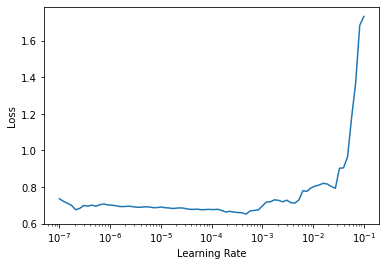

In [ ]:
#slow
learn.lr_find(suggestions=True)

In [ ]:
#slow
learn.fit_one_cycle(3, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.721604,0.661438,0.535000,00:19
1,0.599007,0.582197,0.680000,00:19
2,0.482172,0.504730,0.825000,00:19


And here we creat a @typedispatched impelmentation of `Learner.show_results`.

In [ ]:
#export
@typedispatch
def show_results(x:HF_BaseInput, y, samples, outs, hf_tokenizer, ctxs=None, max_n=6, **kwargs):        
    if ctxs is None: ctxs = get_empty_df(min(len(samples), max_n))
        
    samples = samples = L((TitledStr(hf_tokenizer.decode(inp)),*s[1:]) for inp, s in zip(x[0], samples))
    ctxs = show_batch[object](x, y, samples, max_n=max_n, ctxs=ctxs, **kwargs)

    n_preds_per_input = len(outs[0])
    if (n_preds_per_input == 1): 
        for i,ctx in enumerate(ctxs): ctx['target'] = outs[i][0]
    else:
        for pred_idx in range(n_preds_per_input):
            for i,ctx in enumerate(ctxs):  ctx[f'target{pred_idx+1}'] = outs[i][pred_idx]
        
    display_df(pd.DataFrame(ctxs))
    return ctxs

In [ ]:
learn.show_results(hf_tokenizer=hf_tokenizer, max_n=2)

,text,category,target
0,"<s>The trouble with the book, ""Memoirs of a Geisha"" is that it had Japanese surfaces but underneath the surfaces it was all an American man's way of thinking. Reading the book is like watching a magnificent ballet with great music, sets, and costumes yet performed by barnyard animals dressed in those costumesso far from Japanese ways of thinking were the characters.<br /><br />The movie isn't about Japan or real geisha. It is a story about a few American men's mistaken ideas about Japan and geisha filtered through their own ignorance and misconceptions. So what is this movie if it isn't about Japan or geisha? Is it pure fantasy as so many people have said? Yes, but then why make it into an American fantasy?<br /><br />There were so many missed opportunities. Imagine a culture where there are no puritanical hang-ups, no connotations of sin about sex. Sex is natural and normal. How is sex handled in this movie? Right. Like it was dirty. The closest thing to a sex scene in the movie has Sayuri wrinkling up her nose and grimacing with distaste for five seconds as if the man trying to mount her had dropped a handful of cockroaches on her crotch. <br /><br />Does anyone actually enjoy sex in this movie? Nope. One character is said to be promiscuous but all we see is her pushing away her lover because it looks like she doesn't want to get caught doing something dirty. Such typical American puritanism has no place in a movie about Japanese geisha.<br /><br />Did Sayuri enjoy her first ravishing by some old codger after her cherry was auctioned off? Nope. She lies there like a cold slab of meat on a chopping block. Of course she isn't supposed to enjoy it. And that is what I mean about this movie. Why couldn't they have given her something to enjoy? Why does all the sex have to be sinful and wrong?<br /><br />Behind Mameha the Chairman was Sayuri's secret patron, and as such he was behind the auction of her virginity. He could have rigged the auction and won her himself. Nobu didn't even bid. So why did the Chairman let that old codger win her and, reeking of old-man stink, get his fingers all over her naked body? Would any woman ever really forgive a man for that?<br /><br />Let's</s>",negative,negative
1,"<s>How viewers react to this new ""adaption"" of Shirley Jackson's book, which was promoted as NOT being a remake of the original 1963 movie (true enough), will be based, I suspect, on the following: those who were big fans of either the book or original movie are not going to think much of this one...and those who have never been exposed to either, and who are big fans of Hollywood's current trend towards ""special effects"" being the first and last word in how ""good"" a film is, are going to love it.<br /><br />Things I did not like about this adaption:<br /><br />1. It was NOT a true adaption of the book. From the articles I had read, this movie was supposed to cover other aspects in the book that the first one never got around to. And, that seemed reasonable, no film can cover a book word for word unless it is the length of THE STAND! (And not even then) But, there were things in this movie that were never by any means ever mentioned or even hinted at, in the movie. Reminded me of the way they decided to kill off the black man in the original movie version of THE SHINING. I didn't like that, either. What the movie's press release SHOULD have said is...""We got the basic, very basic, idea from Shirley Jackson's book, we kept the same names of the house and several (though not all) of the leading character's names, but then we decided to write our own story, and, what the heck, we watched THE CHANGELING and THE SHINING and GHOST first, and decided to throw in a bit of them, too.""<br /><br />2. They completely lost the theme of a parapyschologist inviting carefully picked guest who had all had brushes with the paranormal in their pasts, to investigate a house that truly seemed to have been ""born bad""

In [ ]:
learn.predict('I really liked the movie')

('negative', tensor(0), tensor([0.5074, 0.4926]))

In [ ]:
learn.unfreeze()

In [ ]:
#slow
learn.fit_one_cycle(3, lr_max=slice(1e-6, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.304693,0.259567,0.915000,00:50
1,0.127397,0.277010,0.910000,00:50
2,0.105859,0.273170,0.920000,00:50


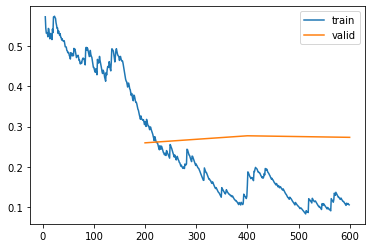

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(hf_tokenizer=hf_tokenizer, max_n=2)

,text,category,target
0,"<s>The trouble with the book, ""Memoirs of a Geisha"" is that it had Japanese surfaces but underneath the surfaces it was all an American man's way of thinking. Reading the book is like watching a magnificent ballet with great music, sets, and costumes yet performed by barnyard animals dressed in those costumesso far from Japanese ways of thinking were the characters.<br /><br />The movie isn't about Japan or real geisha. It is a story about a few American men's mistaken ideas about Japan and geisha filtered through their own ignorance and misconceptions. So what is this movie if it isn't about Japan or geisha? Is it pure fantasy as so many people have said? Yes, but then why make it into an American fantasy?<br /><br />There were so many missed opportunities. Imagine a culture where there are no puritanical hang-ups, no connotations of sin about sex. Sex is natural and normal. How is sex handled in this movie? Right. Like it was dirty. The closest thing to a sex scene in the movie has Sayuri wrinkling up her nose and grimacing with distaste for five seconds as if the man trying to mount her had dropped a handful of cockroaches on her crotch. <br /><br />Does anyone actually enjoy sex in this movie? Nope. One character is said to be promiscuous but all we see is her pushing away her lover because it looks like she doesn't want to get caught doing something dirty. Such typical American puritanism has no place in a movie about Japanese geisha.<br /><br />Did Sayuri enjoy her first ravishing by some old codger after her cherry was auctioned off? Nope. She lies there like a cold slab of meat on a chopping block. Of course she isn't supposed to enjoy it. And that is what I mean about this movie. Why couldn't they have given her something to enjoy? Why does all the sex have to be sinful and wrong?<br /><br />Behind Mameha the Chairman was Sayuri's secret patron, and as such he was behind the auction of her virginity. He could have rigged the auction and won her himself. Nobu didn't even bid. So why did the Chairman let that old codger win her and, reeking of old-man stink, get his fingers all over her naked body? Would any woman ever really forgive a man for that?<br /><br />Let's</s>",negative,negative
1,"<s>How viewers react to this new ""adaption"" of Shirley Jackson's book, which was promoted as NOT being a remake of the original 1963 movie (true enough), will be based, I suspect, on the following: those who were big fans of either the book or original movie are not going to think much of this one...and those who have never been exposed to either, and who are big fans of Hollywood's current trend towards ""special effects"" being the first and last word in how ""good"" a film is, are going to love it.<br /><br />Things I did not like about this adaption:<br /><br />1. It was NOT a true adaption of the book. From the articles I had read, this movie was supposed to cover other aspects in the book that the first one never got around to. And, that seemed reasonable, no film can cover a book word for word unless it is the length of THE STAND! (And not even then) But, there were things in this movie that were never by any means ever mentioned or even hinted at, in the movie. Reminded me of the way they decided to kill off the black man in the original movie version of THE SHINING. I didn't like that, either. What the movie's press release SHOULD have said is...""We got the basic, very basic, idea from Shirley Jackson's book, we kept the same names of the house and several (though not all) of the leading character's names, but then we decided to write our own story, and, what the heck, we watched THE CHANGELING and THE SHINING and GHOST first, and decided to throw in a bit of them, too.""<br /><br />2. They completely lost the theme of a parapyschologist inviting carefully picked guest who had all had brushes with the paranormal in their pasts, to investigate a house that truly seemed to have been ""born bad""

In [ ]:
learn.predict("This was a really good movie, ")

('positive', tensor(1), tensor([0.1113, 0.8887]))

In [ ]:
learn.predict("Acting was so bad it was almost funny.")

('negative', tensor(0), tensor([0.9970, 0.0030]))

And what about inference?
```
learn.export(fname='seq_class_learn_export.pkl')

inf_learn = load_learner(fname='seq_class_learn_export.pkl')
inf_learn.predict("This movie should not be seen by anyone!!!!")
```

In [ ]:
#hide
learn.export(fname='seq_class_learn_export.pkl')

In [ ]:
#hide
inf_learn = load_learner(fname='seq_class_learn_export.pkl')
inf_learn.predict("This movie should not be seen by anyone!!!!")

('negative', tensor(0), tensor([0.9816, 0.0184]))

### Question Answer

Given a document (context) and a question, the objective of these models is to predict the start and end token of the correct answer as it exists in the context.

In [ ]:
#export
class HF_QstAndAnsModelWrapper(HF_BaseModelWrapper):
    """A custom model wrapper for question answer models since we need all the outputs (not just the first)"""
    def forward(self, x):
        model_kwargs = {}
        model_kwargs['input_ids'] = x[0]
        if (self._include_arg('token_type_ids', x[1])): model_kwargs['token_type_ids'] = x[1]
        if (self._include_arg('attention_mask', x[2])): model_kwargs['attention_mask'] = x[2]
        
        outputs = self.hf_model(**model_kwargs)
        return outputs

And here we provide a custom loss function our question answer task, expanding on some techniques learned from here and here.

In fact, this new loss function can be used in many other multi-modal architectures, with any mix of loss functions.  For example, this can be ammended to include the `is_impossible` task, as well as the start/end token tasks in the SQUAD v2 dataset.

In [ ]:
#export
class MultiTargetLoss(Module):
    """Provides the ability to apply different loss functions to multi-modal targets/predictions"""
    def __init__(self, funcs=[F.cross_entropy, F.cross_entropy], 
                 func_kwargs=[{}, {}], 
                 weights=[1, 1],
                 activation_funcs=[partial(F.softmax, dim=-1), partial(F.softmax, dim=-1)],
                 decode_funcs =[partial(torch.argmax, dim=-1), partial(torch.argmax, dim=-1)],
                 reduction='mean'):
        
        store_attr(self, 'funcs, func_kwargs, weights, activation_funcs, decode_funcs, reduction')

    def forward(self, outputs, *targets):
        for i, func, func_kwargs, weights, output, target in zip(range(len(outputs)), 
                                                                 self.funcs, self.func_kwargs, self.weights, 
                                                                 outputs, targets):
            
            if i == 0: 
                loss = weights * func(output, target, reduction=self.reduction, **func_kwargs) 
            else: 
                loss += weights * func(output, target, reduction=self.reduction, **func_kwargs) 
                
        return loss
    
    def activation(self, outs): 
        acts = [ self.activation_funcs[i](o) for i, o in enumerate(outs) ]
        return acts

    def decodes(self, outs):   
        decodes = [ self.decode_funcs[i](o) for i, o in enumerate(outs) ]
        return decodes


Again, we'll use a subset of pre-processed SQUAD v2 for our purposes below.

In [ ]:
path = Path('./')
squad_df = pd.read_csv(path/'squad_sample.csv'); len(squad_df)

1000

In [ ]:
squad_df.head(2)

,title,context,question_id,question_text,is_impossible,answer_text,answer_start,answer_end
0,New_York_City,"The New York City Fire Department (FDNY), provides fire protection, technical rescue, primary response to biological, chemical, and radioactive hazards, and emergency medical services for the five boroughs of New York City. The New York City Fire Department is the largest municipal fire department in the United States and the second largest in the world after the Tokyo Fire Department. The FDNY employs approximately 11,080 uniformed firefighters and over 3,300 uniformed EMTs and paramedics. The FDNY's motto is New York's Bravest.",56d1076317492d1400aab78c,What does FDNY stand for?,False,New York City Fire Department,4,33
1,Cyprus,"Following the death in 1473 of James II, the last Lusignan king, the Republic of Venice assumed control of the island, while the late king's Venetian widow, Queen Catherine Cornaro, reigned as figurehead. Venice formally annexed the Kingdom of Cyprus in 1489, following the abdication of Catherine. The Venetians fortified Nicosia by building the Venetian Walls, and used it as an important commercial hub. Throughout Venetian rule, the Ottoman Empire frequently raided Cyprus. In 1539 the Ottomans destroyed Limassol and so fearing the worst, the Venetians also fortified Famagusta and Kyrenia.",572e7f8003f98919007566df,In what year did the Ottomans destroy Limassol?,False,1539,481,485


In [ ]:
pretrained_model_name = 'bert-large-uncased-whole-word-masking-finetuned-squad'
hf_tokenizer_cls = BertTokenizer
hf_model_cls = HF_MODELS.BertForQuestionAnswering

hf_arch, hf_tokenizer, hf_config, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name,
                                                                               hf_tokenizer_cls,
                                                                               hf_model_cls)

In [ ]:
def pre_process_squad(row):
    context, qst, ans = row['context'], row['question_text'], row['answer_text']
    
    tok_input = hf_tokenizer.convert_ids_to_tokens(hf_tokenizer.encode(qst, context))
    tok_ans = hf_tokenizer.tokenize(str(row['answer_text']), 
                                    add_special_tokens=False, 
                                    add_prefix_space=False)
    
    start_idx, end_idx = 0,0
    for idx, tok in enumerate(tok_input):
        try:
            if (tok == tok_ans[0] and tok_input[idx:idx + len(tok_ans)] == tok_ans): 
                start_idx, end_idx = idx, idx + len(tok_ans)
                break
        except: pass
            
    row['tokenized_input'] = tok_input
    row['tokenized_input_len'] = len(tok_input)
    row['tok_answer_start'] = start_idx
    row['tok_answer_end'] = end_idx
    
    return row

In [ ]:
squad_df = squad_df.apply(pre_process_squad, axis=1)

Token indices sequence length is longer than the specified maximum sequence length for this model (16 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (12 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
#hide
squad_df.head(2)

,title,context,question_id,question_text,is_impossible,answer_text,answer_start,answer_end,tokenized_input,tokenized_input_len,tok_answer_start,tok_answer_end
0,New_York_City,"The New York City Fire Department (FDNY), provides fire protection, technical rescue, primary response to biological, chemical, and radioactive hazards, and emergency medical services for the five boroughs of New York City. The New York City Fire Department is the largest municipal fire department in the United States and the second largest in the world after the Tokyo Fire Department. The FDNY employs approximately 11,080 uniformed firefighters and over 3,300 uniformed EMTs and paramedics. The FDNY's motto is New York's Bravest.",56d1076317492d1400aab78c,What does FDNY stand for?,False,New York City Fire Department,4,33,"[[CLS], what, does, f, ##d, ##ny, stand, for, ?, [SEP], the, new, york, city, fire, department, (, f, ##d, ##ny, ), ,, provides, fire, protection, ,, technical, rescue, ,, primary, response, to, biological, ,, chemical, ,, and, radioactive, hazards, ,, and, emergency, medical, services, for, the, five, boroughs, of, new, york, city, ., the, new, york, city, fire, department, is, the, largest, municipal, fire, department, in, the, united, states, and, the, second, largest, in, the, world, after, the, tokyo, fire, department, ., the, f, ##d, ##ny, employs, approximately, 11, ,, 08, ##0, unif...",123,11,16
1,Cyprus,"Following the death in 1473 of James II, the last Lusignan king, the Republic of Venice assumed control of the island, while the late king's Venetian widow, Queen Catherine Cornaro, reigned as figurehead. Venice formally annexed the Kingdom of Cyprus in 1489, following the abdication of Catherine. The Venetians fortified Nicosia by building the Venetian Walls, and used it as an important commercial hub. Throughout Venetian rule, the Ottoman Empire frequently raided Cyprus. In 1539 the Ottomans destroyed Limassol and so fearing the worst, the Venetians also fortified Famagusta and Kyrenia.",572e7f8003f98919007566df,In what year did the Ottomans destroy Limassol?,False,1539,481,485,"[[CLS], in, what, year, did, the, ottomans, destroy, lima, ##sso, ##l, ?, [SEP], following, the, death, in, 147, ##3, of, james, ii, ,, the, last, lu, ##si, ##gnan, king, ,, the, republic, of, venice, assumed, control, of, the, island, ,, while, the, late, king, ', s, venetian, widow, ,, queen, catherine, corn, ##aro, ,, reigned, as, figure, ##head, ., venice, formally, annexed, the, kingdom, of, cyprus, in, 148, ##9, ,, following, the, abd, ##ication, of, catherine, ., the, venetian, ##s, fortified, nico, ##sia, by, building, the, venetian, walls, ,, and, used, it, as, an, important, comm...",139,110,112


In [ ]:
max_seq_len= 128

In [ ]:
squad_df = squad_df[(squad_df.tokenized_input_len < max_seq_len) & (squad_df.is_impossible == False)]

In [ ]:
vocab = list(range(max_seq_len))
# vocab = dict(enumerate(range(max_seq_len)));

In [ ]:
# (optional): override HF_BatchTransform defaults
hf_batch_tfm = HF_BatchTransform(hf_arch, hf_tokenizer, task=ForQuestionAnsweringTask(),
                                 max_seq_len=128, truncation_strategy=None)

blocks = (
    HF_TextBlock.from_df(text_cols_lists=[['question_text'],['context']], 
                         hf_arch=hf_arch, hf_tokenizer=hf_tokenizer, hf_batch_tfm=hf_batch_tfm),
    CategoryBlock(vocab=vocab),
    CategoryBlock(vocab=vocab)
)

# can't export lambda functions, so made the getter a standard method
def get_x(x): 
    return (x.text0, x.text1)


dblock = DataBlock(blocks=blocks, 
                   get_x=get_x,
                   get_y=[ColReader('tok_answer_start'), ColReader('tok_answer_end')],
                   splitter=RandomSplitter(),
                   n_inp=1)

In [ ]:
dls = dblock.dataloaders(squad_df, bs=4)

In [ ]:
len(dls.vocab), dls.vocab[1], dls.vocab[2]

(3, (#128) [0,1,2,3,4,5,6,7,8,9...], (#128) [0,1,2,3,4,5,6,7,8,9...])

In [ ]:
dls.show_batch(hf_tokenizer=hf_tokenizer, max_n=2)

,text,category,category_
0,"[CLS] who was the season two winner of american idol? [SEP] ruben studdard emerged as the winner, beating clay aiken by a small margin. out of a total of 24 million votes, studdard finished just 134, 000 votes ahead of aiken. this slim margin of victory was controversial due to the large number of calls that failed to get through. in an interview prior to season five, executive producer nigel lythgoe indicated that aiken had led the fan voting from the wildcard week onward until the finale. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]",12,16
1,"[CLS] how many people can nanjing olympic sports center's natatorium hold? [SEP] in 2005, in order to host the 10th national game of people's republic of china, there was a new stadium, nanjing olympic sports center, constructed in nanjing. compared to wutaishan sports center, which the major stadium's capacity is 18, 500, nanjing olympic sports center has a more advanced stadium which is big enough to seat 60, 000 spectators. its gymnasium has capacity of 13, 000, and natatorium of capacity 3, 000. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]",106,109


In [ ]:
model = HF_QstAndAnsModelWrapper(hf_model)

In [ ]:
learn = Learner(dls, 
                model,
                opt_func=partial(Adam, decouple_wd=True),
                #cbs=[MixedPrecision(clip=0.1)],
                splitter=hf_splitter)

learn.loss_func=MultiTargetLoss()
learn.create_opt()             # -> will create your layer groups based on your "splitter" function
learn.freeze()

Notice above how I had to define the loss function *after* creating the `Learner` object.  I'm not sure why, but the `MultiTargetLoss` above prohibits the learner from being exported if I do.

In [ ]:
# learn.summary()

In [ ]:
print(len(learn.opt.param_groups))

4


In [ ]:
x, y_start, y_end = dls.one_batch()
preds = learn.model(x)
len(preds),preds[0].shape

(2, torch.Size([4, 128]))

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=6.309573450380412e-07)

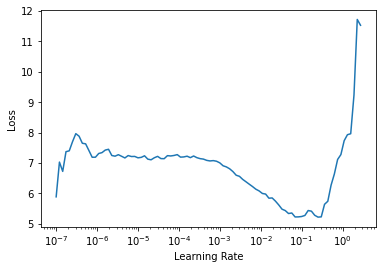

In [ ]:
#slow
learn.lr_find(suggestions=True)

In [ ]:
#slow
learn.fit_one_cycle(3, lr_max=1e-3)

epoch,train_loss,valid_loss,time
0,4.480113,2.917010,00:05
1,2.900930,2.646234,00:05
2,2.333122,2.581568,00:05


In [ ]:
learn.show_results(hf_tokenizer=hf_tokenizer, max_n=2)

,text,category,category_,target1,target2
0,"[CLS] what minority nationality is most common? [SEP] as in most of eastern china the ethnic makeup of nanjing is predominantly han nationality ( 98. 56 percent ), with 50 other minority nationalities. in 1999, 77, 394 residents belonged to minority nationalities, among which the vast majority ( 64, 832 ) were hui nationalities, contributing 83. 76 percent to the minority population. the second and third largest minority groups were manchu ( 2, 311 ) and zhuang ( 533 ) nationalities. most of the minority nationalities resided in jianye district, comprising 9. 13 percent of the district's population. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]",62,64,62,64
1,"[CLS] what was introduced by president barack obama in june 2009? [SEP] united states president barack obama and key advisers introduced a series of regulatory proposals in june 2009. the proposals address consumer protection, executive pay, bank financial cushions or capital requirements, expanded regulation of the shadow banking system and derivatives, and enhanced authority for the federal reserve to safely wind - down systemically important institutions, among others. in january 2010, obama proposed additional regulations limiting the ability of banks to engage in proprietary trading. the proposals were dubbed "" the volcker rule "", in recognition of paul volcker, who has publicly argued for the proposed changes. [SEP] [PAD] [PAD] [PAD] [PAD]",22,27,22,24


In [ ]:
inf_df = pd.DataFrame.from_dict([{
    'text1': 'George Lucas created Star Wars in 1977. He directed and produced it.', 
    'text0': 'What did George Lucas make?'
}], 
    orient='columns')

learn.predict(inf_df.iloc[0])

(('11', '13'),
 tensor([11]),
 tensor([[2.7779e-07, 3.6446e-07, 1.9230e-08, 5.3274e-08, 3.1259e-08, 3.5415e-08,
          1.9435e-09, 2.7781e-07, 2.8515e-04, 1.3347e-05, 1.3106e-03, 9.9819e-01,
          3.9070e-05, 2.2850e-06, 1.5176e-05, 2.8034e-07, 8.3471e-05, 4.1998e-05,
          1.9266e-07, 1.9071e-05, 1.4149e-06, 2.7775e-07, 2.7893e-07, 1.1906e-09,
          1.3245e-09, 1.2379e-09, 1.2392e-09, 1.2635e-09, 1.3031e-09, 1.2888e-09,
          1.2062e-09, 1.2503e-09, 1.2900e-09, 1.2646e-09, 1.1534e-09, 1.1313e-09,
          1.1860e-09, 1.1833e-09, 1.1344e-09, 1.1402e-09, 1.1506e-09, 1.1880e-09,
          1.2131e-09, 1.1750e-09, 1.2224e-09, 1.2354e-09, 1.2197e-09, 1.1989e-09,
          1.2123e-09, 1.2141e-09, 1.2659e-09, 1.2386e-09, 1.2268e-09, 1.2544e-09,
          1.3276e-09, 1.3276e-09, 1.2755e-09, 1.2394e-09, 1.2531e-09, 1.3414e-09,
          1.3117e-09, 1.2232e-09, 1.1983e-09, 1.2316e-09, 1.3057e-09, 1.2222e-09,
          1.1894e-09, 1.2096e-09, 1.2231e-09, 1.2907e-09, 1.2181e-09

Note that there is a bug currently in fastai v2 (or with how I'm assembling everything) that currently prevents us from seeing the decoded predictions and probabilities for the "end" token.

In [ ]:
inf_df = pd.DataFrame.from_dict([{
    'text1': 'George Lucas created Star Wars in 1977. He directed and produced it.', 
    'text0': 'When was Star Wars made?'
}], 
    orient='columns')

test_dl = dls.test_dl(inf_df)
inp, probs, _, preds = learn.get_preds(dl=test_dl, with_input=True, with_decoded=True)

In [ ]:
hf_tokenizer.convert_ids_to_tokens(inp[0].tolist()[0], 
                                   skip_special_tokens=False)[torch.argmax(probs[0]):torch.argmax(probs[1])]

['1977']

In [ ]:
learn.unfreeze()

In [ ]:
#slow
learn.fit_one_cycle(3, lr_max=slice(1e-7, 1e-4))

epoch,train_loss,valid_loss,time
0,1.788620,2.438361,00:15
1,1.712483,2.321153,00:15
2,1.565090,2.301660,00:15


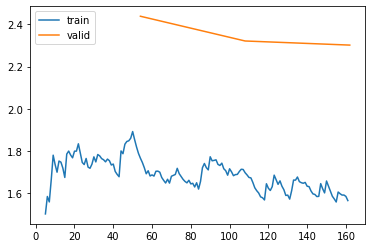

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(hf_tokenizer=hf_tokenizer, max_n=2)

,text,category,category_,target1,target2
0,"[CLS] what minority nationality is most common? [SEP] as in most of eastern china the ethnic makeup of nanjing is predominantly han nationality ( 98. 56 percent ), with 50 other minority nationalities. in 1999, 77, 394 residents belonged to minority nationalities, among which the vast majority ( 64, 832 ) were hui nationalities, contributing 83. 76 percent to the minority population. the second and third largest minority groups were manchu ( 2, 311 ) and zhuang ( 533 ) nationalities. most of the minority nationalities resided in jianye district, comprising 9. 13 percent of the district's population. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]",62,64,62,64
1,"[CLS] the presbyterian denominations from the british isles were inspired by these principles in what document? [SEP] presbyterian denominations that trace their heritage to the british isles usually organise their church services inspired by the principles in the directory of public worship, developed by the westminster assembly in the 1640s. this directory documented reformed worship practices and theology adopted and developed over the preceding century by british puritans, initially guided by john calvin and john knox. it was enacted as law by the scottish parliament, and became one of the foundational documents of presbyterian church legislation elsewhere. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]",39,43,38,43


In [ ]:
learn.predict(inf_df.iloc[0])

(('14', '15'),
 tensor([14]),
 tensor([[5.2429e-07, 1.0751e-06, 1.2344e-07, 7.1526e-08, 4.2704e-08, 4.0225e-07,
          1.9536e-08, 5.2432e-07, 3.2047e-05, 4.4677e-06, 4.5084e-05, 6.0269e-05,
          1.5427e-06, 5.2047e-03, 9.9464e-01, 9.5540e-07, 7.2824e-07, 4.7821e-07,
          4.1823e-08, 4.0589e-07, 4.1484e-07, 5.2420e-07, 5.2498e-07, 3.1706e-09,
          3.7625e-09, 3.4495e-09, 3.4231e-09, 3.3450e-09, 3.4393e-09, 3.1844e-09,
          3.2187e-09, 3.2168e-09, 3.6417e-09, 3.5894e-09, 3.1729e-09, 3.1169e-09,
          3.1812e-09, 3.1393e-09, 3.0958e-09, 3.1714e-09, 3.0414e-09, 3.1024e-09,
          3.2231e-09, 3.1481e-09, 3.1397e-09, 3.2090e-09, 3.0725e-09, 3.1133e-09,
          3.1626e-09, 3.1040e-09, 3.5654e-09, 3.3023e-09, 3.2348e-09, 3.2845e-09,
          3.2959e-09, 3.4033e-09, 3.2358e-09, 3.2315e-09, 3.2085e-09, 3.7391e-09,
          3.7072e-09, 3.2807e-09, 3.2378e-09, 3.2480e-09, 3.3779e-09, 3.1852e-09,
          3.2223e-09, 3.1525e-09, 3.1821e-09, 3.7477e-09, 3.2164e-09

In [ ]:
preds, pred_classes, probs = learn.predict(inf_df.iloc[0])
preds

('14', '15')

And what about inference?

Note that I had to replace the loss function because of the above-mentioned issue to exporting the model with the `MultiTargetLoss` loss function.  After getting our inference learner, we put it back and we're good to go!

```
learn.loss_func = nn.CrossEntropyLoss()
learn.export(fname='q_and_a_learn_export.pkl')

inf_learn = load_learner(fname='q_and_a_learn_export.pkl')
inf_learn.loss_func = MultiTargetLoss()

inf_df = pd.DataFrame.from_dict([
    {'text0': 'George Lucas created Star Wars in 1977. He directed and produced it.', 
     'text1': 'Who created Star Wars?'}],
    orient='columns')

inf_learn.predict(inf_df.iloc[0])
```

In [ ]:
#hide
learn.loss_func = nn.CrossEntropyLoss()
learn.export(fname='q_and_a_learn_export.pkl')

In [ ]:
#hide
inf_learn = load_learner(fname='q_and_a_learn_export.pkl')
inf_learn.loss_func = MultiTargetLoss()

inf_df = pd.DataFrame.from_dict([
    {'text0': 'George Lucas created Star Wars in 1977. He directed and produced it.', 
     'text1': 'Who created Star Wars?'}],
    orient='columns')

inf_learn.predict(inf_df.iloc[0])

(('1', '3'),
 tensor([1]),
 tensor([[1.3551e-06, 9.9929e-01, 5.1933e-04, 1.0301e-05, 1.1227e-04, 4.8823e-07,
          2.0091e-06, 4.1706e-05, 1.5822e-07, 1.2807e-05, 2.3620e-06, 1.2477e-07,
          1.9063e-06, 2.7669e-07, 5.1084e-08, 1.3553e-06, 1.0226e-06, 4.1501e-07,
          5.2202e-07, 6.8922e-08, 4.2556e-08, 1.3515e-06, 1.1672e-08, 1.2673e-08,
          1.2405e-08, 9.0131e-09, 9.0259e-09, 8.3373e-09, 8.2034e-09, 8.7948e-09,
          8.0056e-09, 7.9105e-09, 8.6302e-09, 7.9693e-09, 8.1386e-09, 8.2877e-09,
          8.0753e-09, 8.3181e-09, 1.0525e-08, 9.6473e-09, 9.7472e-09, 9.6426e-09,
          8.5099e-09, 8.5842e-09, 8.2297e-09, 8.0291e-09, 8.6598e-09, 1.0711e-08,
          9.5003e-09, 8.5700e-09, 8.4174e-09, 8.1731e-09, 8.6809e-09, 8.1606e-09,
          7.5743e-09, 7.3992e-09, 7.6934e-09, 7.5084e-09, 7.5742e-09, 7.7734e-09,
          7.6950e-09, 8.3415e-09, 7.7933e-09, 7.8519e-09, 7.7465e-09, 8.2211e-09,
          7.9630e-09, 8.0810e-09, 8.6810e-09, 8.4447e-09, 1.5384e-08, 9

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 01_data.ipynb.
Converted 02_modeling.ipynb.
Converted index.ipynb.
